## Factor Analysis Gibbs sampling

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# simulation for two neurons
np.random.seed(42)

n = 2 # neurons
k = 2 # latent dimension

mean = np.random.rand(n, 1)
r = np.random.uniform(.5, 1.5, size=n) # noise std
R = np.diag(r**2)
C = np.array([[1., -.9], [1., -0.9]]) # factor loadings
cov_mat = R + C @ C.T

truncation_boundaries = np.array([[0, np.inf]]*n)

pnoise = stats.norm(np.zeros(len(r)), r)
pz = stats.norm(0, 1)

samples = np.random.multivariate_normal(mean[:, 0], cov_mat, size=50000)

In [3]:
geql = np.prod(samples >= truncation_boundaries.T[0], axis=1)
lequ = np.prod(samples <= truncation_boundaries.T[1], axis=1)
valid_samples = (geql * lequ).astype(bool)
invalid_samples = ~valid_samples

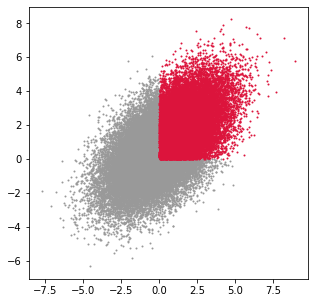

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(*samples[invalid_samples].T, color='.6', s=1)
ax.scatter(*samples[valid_samples].T, color='crimson', s=1)

In [8]:
z_sample = np.zeros((k, 1))
noise_sample = np.zeros((n, 1))

N = 10000 # samples
N_burnin = 100

tsamples = []
noise_samples = []
zsamples = []
for iter_n in tqdm(range(N + N_burnin)):

    # Sample 𝜖 given 𝑧
    truncation_lower_boundary_noise = truncation_boundaries[:, [0]] - mean - C @ z_sample
    truncation_upper_boundary_noise = truncation_boundaries[:, [1]] - mean - C @ z_sample
    truncation_boundaries_noise = np.hstack((truncation_lower_boundary_noise, truncation_upper_boundary_noise))

    loc = pnoise.cdf(truncation_boundaries_noise.T[0])
    scale = pnoise.cdf(truncation_boundaries_noise.T[1]) - loc
    uniform_sample = stats.uniform(loc, scale).rvs()
    noise_sample = pnoise.ppf(uniform_sample)[:, None]


    # Sample 𝑧𝑖 given 𝜖 and 𝑧∖𝑖
    for latent_ind in np.arange(k):
        latent_notind = np.where(np.arange(k) != latent_ind)[0]

        truncation_lower_boundary_z_ = (truncation_boundaries[:, [0]] - mean - C[:, latent_notind] @ z_sample[latent_notind] - noise_sample) / C[:, [latent_ind]]
        truncation_upper_boundary_z_ = (truncation_boundaries[:, [1]] - mean - C[:, latent_notind] @ z_sample[latent_notind] - noise_sample) / C[:, [latent_ind]]
        eta = (np.sign(C[:, [latent_ind]]) + 1) / 2
        aa = np.hstack((truncation_lower_boundary_z_, truncation_upper_boundary_z_))
        truncation_lower_boundary_z, truncation_upper_boundary_z = np.take_along_axis(aa, np.hstack((1-eta, eta)).astype(int), axis=1).T
        truncation_boundaries_z = np.hstack([truncation_lower_boundary_z.max(), truncation_upper_boundary_z.min()])

        ulb, uub = pz.cdf(truncation_boundaries_z)
        uniform_sample = stats.uniform(ulb, uub-ulb).rvs()
        new_z_sample = pz.ppf(uniform_sample)

        z_sample[[latent_ind]] = new_z_sample
    
    if iter_n >= N_burnin:
        noise_samples.append(noise_sample.copy())
        zsamples.append(z_sample.copy())
        tsamples.append(mean + C @ z_sample + noise_sample) 
    
tsamples = np.concatenate(tsamples, axis=1)

100%|██████████| 10100/10100 [01:01<00:00, 163.58it/s]


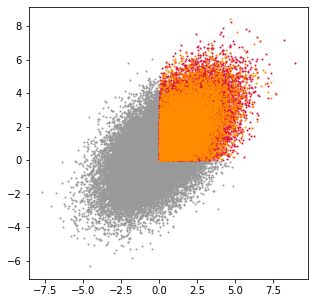

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(*samples[invalid_samples].T, color='.6', s=1)
ax.scatter(*samples[valid_samples].T, color='crimson', s=1)

ax.scatter(*tsamples, color='darkorange', s=1)

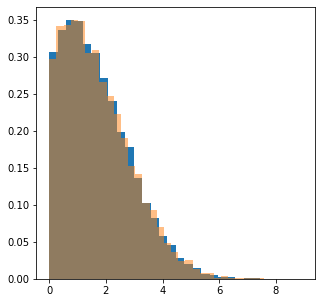

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.hist(samples[valid_samples].T[0], bins=30, density=True);
ax.hist(tsamples[0], bins=30, density=True, alpha=.5);

---